In [3]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import ssd
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [91]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
#%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

In [ ]:
from IPython.display import display
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
import sympy as sym
x,y,z,a,b,c = sym.symbols("x y z a b c")

**A helper function**: Used to display complex numbers in rectangular or polar format and also in normal float or exponential display.

In [5]:
def cpx_fmt(z,mode1='rect',mode2='f',mode3='deg',d1=2,d2=4):
    """
    Helper function for printing formatted complex numbers as %d1.d2f and
    %d1.d2e. The function returns a string that can be displayed using print()
    
    s_out = cpx_fmt(z,mode1='rect',mode2='f',d1=2,d2=4)
    
    mode1 = 'rect' or 'polar' form
    mode2 = 'f' for floating or 'e' for exponential
    
    Mark Wickert January 2016
    """
    if mode1 == 'rect':
        if mode2 == 'f':
            mt = 'f'
        else:
            mt = 'e'
        if z.imag >= 0:
            s_o = '%'+str(d1)+'.'+str(d2)+mt+ ' + j%'+str(d1)+'.'+str(d2)+mt 
            s_out = s_o % (z.real,z.imag)
        else:
            s_o = '%'+str(d1)+'.'+str(d2)+mt+ ' - j%'+str(d1)+'.'+str(d2)+mt
            s_out = s_o % (z.real,abs(z.imag))
    else: # polar format otherwise
        if mode2 == 'f':
            mt = 'f'      
        else:
            mt = 'e'
        s_o = '%'+str(d1)+'.'+str(d2)+mt+ ' /_%'+str(d1)+'.'+str(d2)+mt
        if mode3 == 'deg':
            s_o += ' (deg)'
            s_out = s_o % (abs(z),angle(z)*180/pi)
        else:
            s_o += ' (rad)'
            s_out = s_o % (abs(z),angle(z))            
    return s_out

In [6]:
def mstrip_anal(s,er):
    """
    Microstrip zero thickness strips design function
    
    s = w/h
    er = material relative permittivity
    
    Z0 returned
    e_eff returned
    
    Mark Wickert February 2016
    """
    e_eff = eps_eff(s,er)
    t = (30.67/s)**0.75
    Z0 = 60/sqrt(e_eff) * \
         log((6+(2*pi-6)*exp(-t))/s + sqrt(1+4/s**2))
    return Z0, e_eff

def mstrip_dsgn(Z0,er):
    """
    Mircostrip zero thickness strips design function
    
    Z0 = desired characteristic impedance
    er = material relative permittivity
    
    s = w/h is returned
    e_eff returned
    
    Mark Wickert February 2016
    """
    if Z0 <= (44-2*er):
        q = 60*pi*pi/(Z0*sqrt(er))
        s = 2/pi*((q-1)-log(2*q-1) + \
                 (er-1)/(2*er)*(log(q-1)+0.29-0.52/er))
        
    else:
        p = sqrt((er+1)/2)*Z0/60+(er-1)/(er+1)*(0.23 + 0.12/er)
        s = 8*exp(p)/(exp(2*p)-2)
    e_eff = eps_eff(s,er)
    return s, e_eff

def eps_eff(s,er):
    """
    Find microstrip e_eff given s = w/h and er
    
    Mark Wickert February 2016
    """
    x = 0.56*((er-0.9)/(er+3))**0.05
    y = 1 + 0.02*log((s**4 + 3.7e-4*s**2)/(s**4+0.43)) + \
        0.05*log(1+1.7e-4*s**3)
    e_eff = (er+1)/2 + (er-1)/2*(1+10/s)**(-x*y)
    return e_eff

def mstrip_extra(Z0,er,f = 1e9,h = 1):
    """
    Extra parameters: L', C', beta, \lambda_g
    
    Z0 = characteristic impedance in Ohms
    er = relative permittivity
    f = operatng frequency in Hz
    h = substrate height in m
    
    Mark Wickert February 2016
    """
    c = 3e8 # m/s
    s, e_eff = mstrip_dsgn(Z0,er)
    C_p = sqrt(e_eff)/(Z0*c) # F/m
    L_p = Z0**2*C_p  #H/m
    R_p = 0
    G_p = 0
    alpha = 0
    beta = 2*pi/c*sqrt(e_eff) # rad/m
    lambda_g = c/sqrt(e_eff)/f # m
    # Print formatted results
    print('Line width w = %1.3e mm, Rel. perm: e_eff = %2.3f' % (s*h*1000,e_eff))
    print('Line width w = %1.3e mils (common PCB unit)' % (s*h*1000/0.0254,))
    print('-----------------------------------------------------')
    print("Resistance per unit length: R' = 0 ohms/m")
    print("Inductance per unit length: L' = %1.3e nH/m" % (L_p*1e9,))
    print("Conductance per unit length: G' = 0 S/n")
    print("Capacitance per unit length: C' = %1.3e pF/m" % (C_p*1e12,))
    print('-----------------------------------------------------')
    print('Phase constant: beta = %1.3e rad/m' % beta)
    print('Wavelength in free space: lambda = %1.3e cm' % (c/f*1e2,))
    print('Wavelength in medium (guide): lambda_g = %1.3e cm' % (lambda_g*1e2,))

# Problem 1: Ulaby 2.1
A transmission line of length $l$ connects a load to a sinusoidal voltage source with an oscillation frequency $f$. Assuming that the velocity of wave propagation  on the line is $c$, for which of the following situations is it reasonable to ignore the presence of the transmission line in the solution of the circuit:

## Part a
$l = 20$ cm, $f = 20$ kHz

* To check this out we find the wavelength, $\lambda = c/f$ and see if $l/\lambda <= 0.01$
* From the calculation below we that the $l/\lambda$ is much less than 0.01, so **we may ignore** transmission line effects

In [17]:
# Side calculations
l_a = 20*1e-2 # m
lambda_a = 3e8/20e3 # m
print('l/lambda_a = %1.2e' % (l_a/lambda_a,))

l/lambda_a = 1.33e-05


## Part b
$l = 50$ km, $f = 60$ Hz
* To check this out we find the wavelength, $\lambda = c/f$ and see if $l/\lambda <= 0.01$
* From the calculation below we that the $l/\lambda$ is equal to 0.01, so **we may ignore** transmission line effects

In [18]:
# Side calculations
l_b = 50*1e3 # m
lambda_b = 3e8/60 # m
print('l/lambda_b = %1.2e' % (l_b/lambda_b,))

l/lambda_b = 1.00e-02


## Part c
$l = 20$ cm, $f = 600$ MHz

* To check this out we find the wavelength, $\lambda = c/f$ and see if $l/\lambda <= 0.01$
* From the calculation below we that the $l/\lambda$ is equal to 0.4, so **we may not ignore** transmission line effects

In [19]:
# Side calculations
l_c = 20*1e-2 # m
lambda_c = 3e8/600e6 # m
print('l/lambda_c = %1.2e' % (l_c/lambda_c,))

l/lambda_c = 4.00e-01


## Part d
$l = 1$ mm, $f = 100$ GHz

* To check this out we find the wavelength, $\lambda = c/f$ and see if $l/\lambda <= 0.01$
* From the calculation below we that the $l/\lambda$ is equal to 0.333, so **we may not ignore** transmission line effects

In [20]:
# Side calculations
l_d = 1*1e-3 # m
lambda_d = 3e8/100e9 # m
print('l/lambda_d = %1.2e' % (l_d/lambda_d,))

l/lambda_d = 3.33e-01


# Problem 2: Ulaby 2.2
A twowire copper transmission line is embedded in a dielectric material with $\epsilon_r = 2.6$ and $\sigma = 2\times 10^{-6}$ S/m. Its wires are separated by 3 cm, and their radii are 1 mm each.

## Part a
Calculate the line parameters $R'$, $L'$, $G'$, and $C'$ at $f = 2$ GHz

* To perform this calculation we will program the line parameters equations, similar to what was done in the notes for coax, i.e., `coax_parameters()`

In [33]:
def twoline_parameters(d,D,f,e_r,sigma_c,sigma=1,mu=1,mu_c=1,display=True):
    """
    Find the distributed parameters of the coax line
    
    R_p, L_p, G_p, C_p = coax_parameters(a,b,f,e_r,sigma_c,
                                         sigma=1,mu=1,mu_c=1,
                                         display=True)
    Note: By default display is True, so to supress raw variables
          use a semicolon to terminate the function call.
    
    Mark Wickert February 2016
    """
    e_0 = 8.85e-12 # F/m
    mu_0 = 4*pi*1e-7 # H/m
    Rs = sqrt(pi*f*mu_0*mu_c/sigma_c)
    R_p = 2*Rs/(pi*d) # Ohms/m  
    L_p = mu_0*mu/pi*log((D/d)+sqrt((D/d)**2-1)) #H/m
    G_p = pi*sigma/log((D/d)+sqrt((D/d)**2-1)) # S/m
    C_p = pi*e_0*e_r/log((D/d)+sqrt((D/d)**2-1))
    # Display calculations as opposed to returning the value
    if display:
        print("R' = %2.5f ohms/m" % (R_p,))
        print("L' = %2.2f nH/m" % (L_p*1e9,))
        print("G' = %2.2e S/m" % (G_p,))
        print("C' = %2.2f pF/m" % (C_p*1e12,))
    return R_p, L_p, G_p, C_p

In [34]:
twoline_parameters(2e-3,30e-3,2.0e9,2.6,5.797e7,2e-6);

R' = 3.71487 ohms/m
L' = 1360.03 nH/m
G' = 1.85e-06 S/m
C' = 21.26 pF/m


## Part b
Compare your results with those based on Module 2.1. Include a printout/screeshot of the screen display.

* The Module 2.1 Java applet is located at http://em7e.eecs.umich.edu/ch2/mod2_1/TwoWireGauge.html
* We enter parameters into this applet to produce the following:

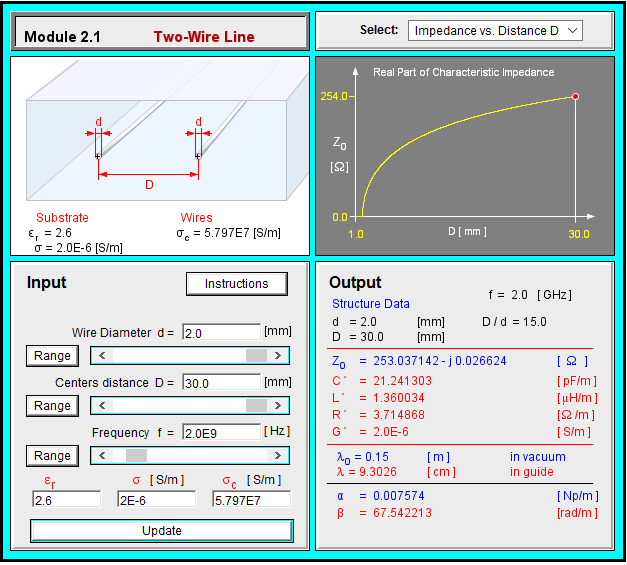

In [22]:
# Import screenshot of Module 2.1
Image('SET3_PROB2B.PNG',width='80%')

* The results of the two methods are in agreement!

# Problem 3: Ulaby 2.6
A coaxial line with inner and outer conductor diameters of 0.5 cm and 1 cm, respectively, is filled with an insulating material with $\epsilon_r = 4.5$ and $\sigma = 10^{-3}$ S/m. The conductors are made of copper.

## Part a
Calculate the line parameters at 1 GHz

* We can use the Python code developed in the lecture notes:

In [43]:
def coax_parameters(a,b,f,e_r,sigma_c,sigma=1,mu=1,mu_c=1,display=True):
    """
    Find the distributed parameters of the coax line
    
    R_p, L_p, G_p, C_p = coax_parameters(a,b,f,e_r,sigma_c,
                                         sigma=1,mu=1,mu_c=1,
                                         display=True)
    Note: By default display is True, so to supress raw variables
          use a semicolon to terminate the function call.
    
    Mark Wickert February 2016
    """
    e_0 = 8.85e-12 # F/m
    mu_0 = 4*pi*1e-7 # H/m
    Rs = sqrt(pi*f*mu_0*mu_c/sigma_c)
    R_p = Rs/(2*pi)*(1/a +1/b) # Ohms/m  
    L_p = mu_0*mu/(2*pi)*log(b/a) #H/m
    G_p = 2*pi*sigma/log(b/a) # S/m
    C_p = 2*pi*e_0*e_r/log(b/a)
    # Display calculations as opposed to returning the value
    if display:
        print("R' = %2.5f ohms/m" % (R_p,))
        print("L' = %2.3f nH/m" % (L_p*1e9,))
        print("G' = %2.6f S/m" % (G_p,))
        print("C' = %2.5f pF/m" % (C_p*1e12,))
    return R_p, L_p, G_p, C_p

In [44]:
coax_parameters(0.5e-2/2,1.0e-2/2,1e9,4.5,5.797e7,1e-3);

R' = 0.78804 ohms/m
L' = 138.629 nH/m
G' = 0.009065 S/m
C' = 361.00249 pF/m


## Part b
Compare your results with those based on Module 2.2. Include a print out of the screen display.

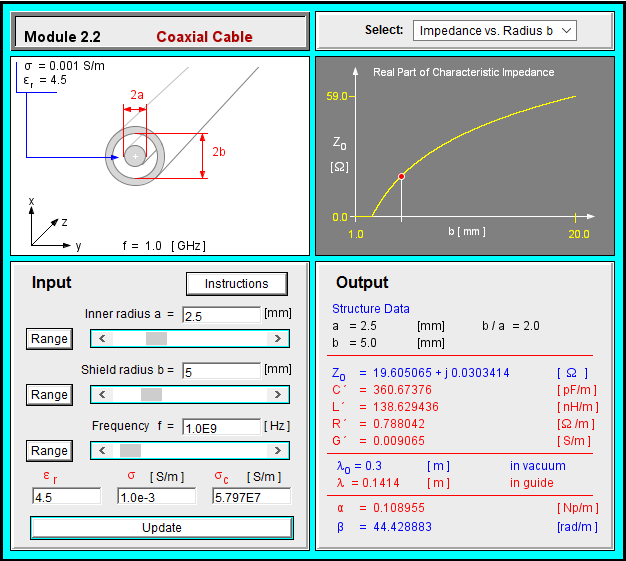

In [36]:
# Import screenshot of Module 2.2
Image('SET3_PROB3B.PNG',width='80%')

* The results of the two methods are in agreement! 

# Problem 4: Ulaby 2.11
A $50\ \Omega$ microstrip uses a 0.6 mm thick alumina substrate with $\epsilon_r = 9$. Use the Java module 2.3 to determine the required strip width $w$. Include a print out of the display.

* In this problem we use the book module 2.3 as well as the Python function `mstrip_dsgn()` developed in the notes as a cross check

### Using the Text Design and Analysis Equations
* Using the Python `mstrip_dsgn()` function obtaining the desired result is simply:

In [46]:
er = 9
h = 0.6 # mm
Z0 = 50 # Ohms
s, e_eff = mstrip_dsgn(Z0, er)
print('w = %1.3f mm' % (s*h,))

w = 0.634 mm


* Try manually iterating $s$ in the analysis expression tonobtain $Z_0 = 50\ \Omega$

In [90]:
er = 9
h = 0.6 # mm
Z0, e_eff = mstrip_anal(0.63191/h, er)
print('Z0 = %1.3f ohms' % (Z0,))

Z0 = 50.000 ohms


* Use `scipy.optimize.fsolve()` with the analysis equation to search for the *root* that gives 50 ohms
* First we have to write a *wrapper function* that just returns Z0 then we can iterate find the $s = w/h$ value giving exactly 50 $Z_0 = \Omega$

In [55]:
def Z0_objective(s,Z0_desired,er):
    """
    Special mstrip function for working with fsolve
    
    Mark Wickert February 2016
    """
    Z0, e_eff = mstrip_anal(s,er)
    return Z0 - Z0_desired # Looking for zero crossing

In [53]:
from scipy.optimize import fsolve

In [93]:
er = 9
h = 0.6 # mm
Z0 = 50 # Ohms
s_result = fsolve(Z0_objective,1.2,args=(Z0,er,),xtol = 1e-5)
print('w = %1.4f mm' % (s_result*h,))

w = 0.6319 mm


* We see that all the methods involving the text equations, analysis or design, result in a similar $w$ value
* Using the direct design equation we obtain $w = 0.634$ mm
* By manually or via `fsolve()` interating the analysis equation we obtain $w = 0.6319$

### Using the Text Module 2.3 Applet
* Using the Module 2.3 app we iterate manually the $s = w/h$ value until 50 $\omega$ is achieved

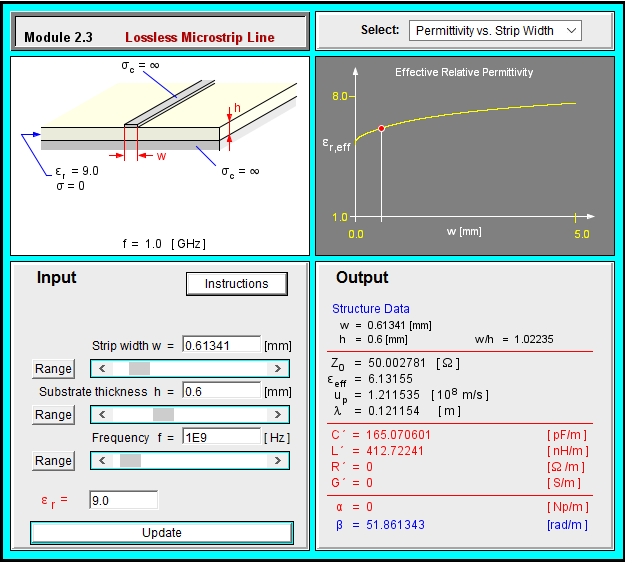

In [45]:
# Import screenshot of Module 2.2
Image('SET3_PROB4.PNG',width='80%')

* The two results are close, but not as close as expected
* In part (a), beyond using the initial `mstrip_dsgn()` function, two additiional interative solutions that use `mstrip_anal()` were tried
* In all cases the Module 2.3 results find a smaller $w$ value than the solutions of part (a)
* Specifcally part (a) gives $w = 0.6319$ mm and Part (b) gives $w = 0.6134$ mm

### A Third Technique Using Saturn PCB Tools
* A **free** tool, *Saturn PCB Design*, which runs under windows is tried next; see [www.saturnpcb.com](www.saturnpcb.com)
* This tool takes into account many realistic conditions, such as finite metal thickness and plating of the bare metal to reduce losses
* Again an iterative process is used, with no plating, and finite thickness strips model as opposed to zero thickness model for the actual microstrip, i.e., from the notes recall $t > 0$ is reality, but the wants to keep things simple so it is using $t = 0$
* To get Saturn to results close to $t=0$ I use the smallest $t$ value available in the program, which is $t = 9\ \mu$m (compared with $t = 0$ in the previous calculations)
* The results are shown below:

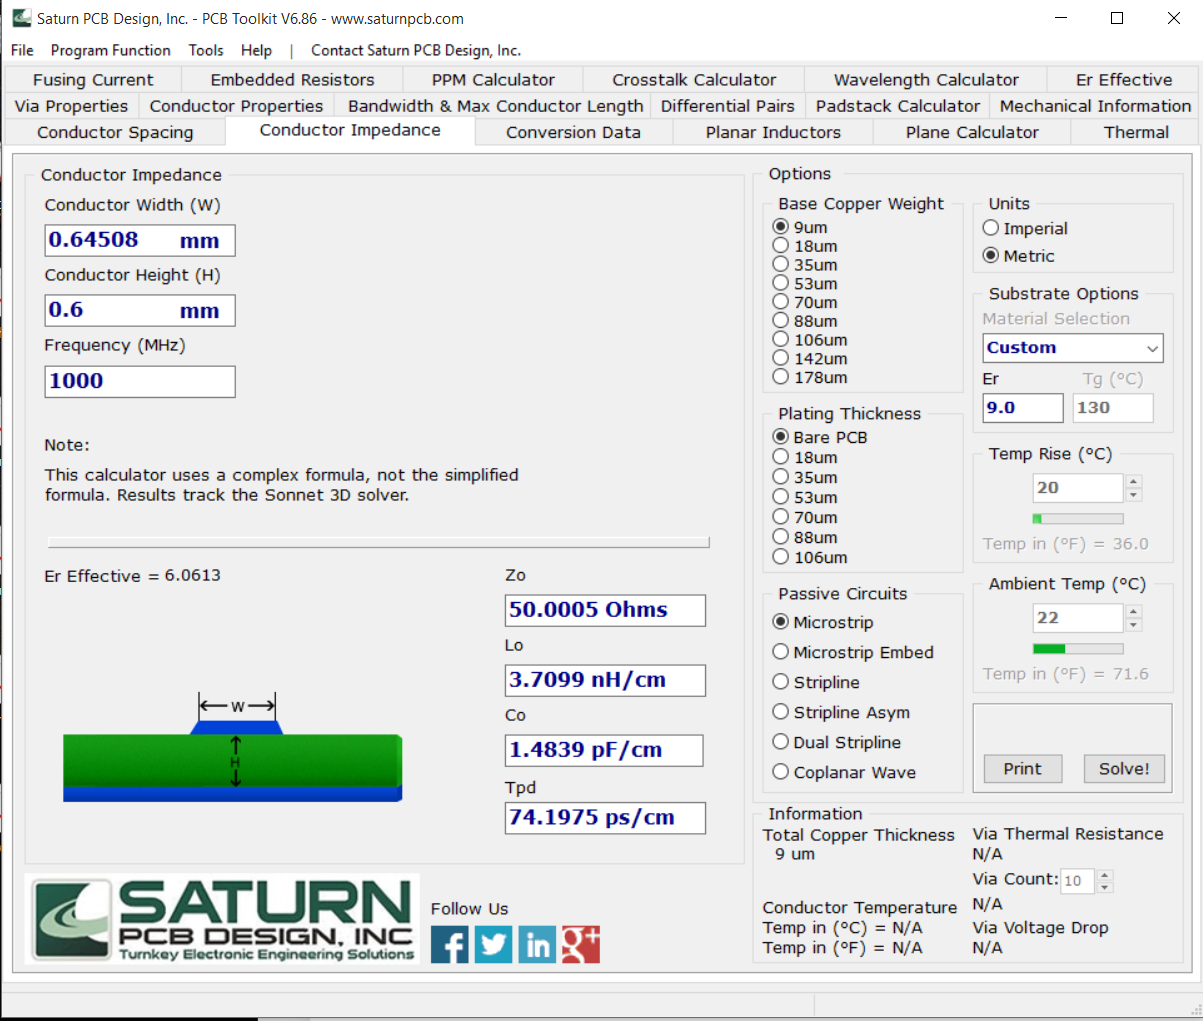

In [95]:
# Import screenshot frm Saturn PCB
Image('SET3_PROB4_SATURN.PNG',width='80%')

* From Saturn PCB we see that $w = 0.6451$ mm is found, this is higher than both of the previous methods
* At this point I trust Saturn PCB tools over the simplifed zero thickness strips of the text and am uncertain about the model used by the Module 3.3 Applet

# Problem 5: Ulaby 2.12
Generate a Plot of $Z_0$ as a function of strip width $w$, over the range from 0.05 mm, for a mircostrip line fabricated in a 0.7 mm thick substrate with $\epsilon_r = 9.8$

* To work this problem we will use the `mstrip_anal()` function developed in the course notes.

In [92]:
w = arange(0.05,5,0.01)
Z0 = zeros_like(w)
e_eff = zeros_like(w)
for k, wk in enumerate(w):
    Z0[k],e_eff[k] = mstrip_anal(wk/0.7, 9.8)
plot(w,Z0)
xlabel(r'$w$ (mm)')
ylabel(r'$Z_0$ (Ohms)')
title(r'Plot of $Z_0$ versus $w$ for $h = 0.7$ mm and $\epsilon_r = 9.8$')
grid();